# Data acquisition notebook
## CT State EV registration data

In [3]:
import pandas as pd 
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import requests
from bs4 import BeautifulSoup

# Get data from the url 

In [4]:
url = 'https://www.atlasevhub.com/materials/state-ev-registration-data/#data'
reqs = requests.get(url)
soup = BeautifulSoup(reqs.text, 'html.parser')

In [5]:
links=[link.get('href') for link in soup.find_all('a') ]
data=[i for i in links if len(i.split('/'))>1 and i.split('/')[1]=='public']
data=[i for i in data if i.split('.')[-1]=='csv']
state_name=[i.split('/')[3].split('_')[0].upper() for i in data]

In [6]:
print(state_name)

['CA', 'CO', 'CT', 'FL', 'MT', 'MI', 'MN', 'NJ', 'NY', 'OR', 'TN', 'TX', 'VT', 'VA', 'WA', 'WI']


In [7]:
# dt=pd.read_csv('https://www.atlasevhub.com/'+data[0])

In [8]:
# dt.to_csv(r'./CA_data.csv',index=False)
dt=pd.read_csv(r'./CA_data.csv')
dt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542443 entries, 0 to 2542442
Data columns (total 9 columns):
 #   Column                        Dtype  
---  ------                        -----  
 0   Vehicle ID                    object 
 1   County GEOID                  object 
 2   Registration Valid Date       object 
 3   DMV ID                        int64  
 4   DMV Snapshot                  object 
 5   Registration Expiration Date  float64
 6   State Abbreviation            object 
 7   Geography                     object 
 8   Vehicle Name                  object 
dtypes: float64(1), int64(1), object(7)
memory usage: 174.6+ MB


In [9]:
dt.head()

,Vehicle ID,County GEOID,Registration Valid Date,DMV ID,DMV Snapshot,Registration Expiration Date,State Abbreviation,Geography,Vehicle Name
0,CA-002-03597\r,06099,2011-01-01,2,CA Registration Data from CA (12/31/2011),NaN,CA,County,Chevrolet Volt
1,CA-002-03598\r,06105,2011-01-01,2,CA Registration Data from CA (12/31/2011),NaN,CA,County,Nissan Leaf
2,CA-002-03599\r,06103,2011-01-01,2,CA Registration Data from CA (12/31/2011),NaN,CA,County,Chevrolet Volt
3,CA-002-03600\r,06099,2011-01-01,2,CA Registration Data from CA (12/31/2011),NaN,CA,County,Tesla Roadster
4,CA-002-03601\r,06099,2011-01-01,2,CA Registration Data from CA (12/31/2011),NaN,CA,County,Tesla Roadster


# Data cleaning

1. *search for NaN*

In [10]:
dt.isna().sum()

Vehicle ID                            0
County GEOID                          0
Registration Valid Date               0
DMV ID                                0
DMV Snapshot                          0
Registration Expiration Date    2542443
State Abbreviation                    0
Geography                             0
Vehicle Name                          0
dtype: int64

Registration Expiration Date is not available, let's drop this column. 

In [11]:
dt=dt.dropna(axis=1)

In [12]:
print(dt.shape)

(2542443, 8)


In [13]:
dt.head()

,Vehicle ID,County GEOID,Registration Valid Date,DMV ID,DMV Snapshot,State Abbreviation,Geography,Vehicle Name
0,CA-002-03597\r,06099,2011-01-01,2,CA Registration Data from CA (12/31/2011),CA,County,Chevrolet Volt
1,CA-002-03598\r,06105,2011-01-01,2,CA Registration Data from CA (12/31/2011),CA,County,Nissan Leaf
2,CA-002-03599\r,06103,2011-01-01,2,CA Registration Data from CA (12/31/2011),CA,County,Chevrolet Volt
3,CA-002-03600\r,06099,2011-01-01,2,CA Registration Data from CA (12/31/2011),CA,County,Tesla Roadster
4,CA-002-03601\r,06099,2011-01-01,2,CA Registration Data from CA (12/31/2011),CA,County,Tesla Roadster


# Remove columns with a unique value
# Add this function in data cleaning class

In [14]:
# Remove columns with a unique value; will also remove columns with only 0 
print(f"removing {sum(dt.nunique()<2)} columns values with a unique value")
print(f"Before: dt.shape={dt.shape}")
dt=dt.loc[:,dt.nunique()>1]
print(f"After: dt.shape={dt.shape} \n")

removing 2 columns values with a unique value
Before: dt.shape=(2542443, 8)
After: dt.shape=(2542443, 6) 



In [15]:
dt.head()

,Vehicle ID,County GEOID,Registration Valid Date,DMV ID,DMV Snapshot,Vehicle Name
0,CA-002-03597\r,06099,2011-01-01,2,CA Registration Data from CA (12/31/2011),Chevrolet Volt
1,CA-002-03598\r,06105,2011-01-01,2,CA Registration Data from CA (12/31/2011),Nissan Leaf
2,CA-002-03599\r,06103,2011-01-01,2,CA Registration Data from CA (12/31/2011),Chevrolet Volt
3,CA-002-03600\r,06099,2011-01-01,2,CA Registration Data from CA (12/31/2011),Tesla Roadster
4,CA-002-03601\r,06099,2011-01-01,2,CA Registration Data from CA (12/31/2011),Tesla Roadster


# We don't need Vehicle ID, DMV ID and DMV Snapshot so let's drop these columns

In [16]:
dt=dt.drop(columns=['Vehicle ID','DMV ID','DMV Snapshot'])
dt.head()

,County GEOID,Registration Valid Date,Vehicle Name
0,06099,2011-01-01,Chevrolet Volt
1,06105,2011-01-01,Nissan Leaf
2,06103,2011-01-01,Chevrolet Volt
3,06099,2011-01-01,Tesla Roadster
4,06099,2011-01-01,Tesla Roadster


# To visualize number of EV registration over the years, find the year of registration from the "Registration Valid Date"
## drop the columns "Registration Valid Date"

In [17]:
dt.insert(3,"year",pd.to_datetime(dt['Registration Valid Date']).dt.year.to_list())
dt=dt.drop(columns=['Registration Valid Date'])
dt.head()

,County GEOID,Vehicle Name,year
0,06099,Chevrolet Volt,2011
1,06105,Nissan Leaf,2011
2,06103,Chevrolet Volt,2011
3,06099,Tesla Roadster,2011
4,06099,Tesla Roadster,2011


# Number of Registrations of EV's in CA from the year 2010 to 2020

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

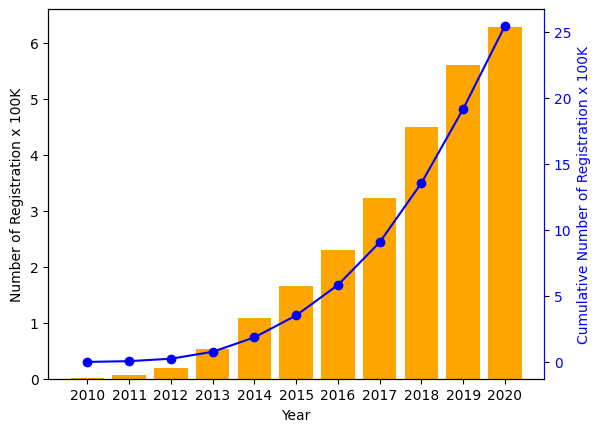

In [19]:
fig,ax=plt.subplots()
x=dt.year.value_counts().sort_index().index
y=0.00001*dt.year.value_counts().sort_index()
ax.bar(x=x,height=y,color='orange')
ax.set_xticks(x)

ax.set_xlabel('Year')
ax.set_ylabel('Number of Registration x 100K')

ax2=ax.twinx()
ax2.plot(x,y.cumsum(),'-o',color='blue')
ax2.spines["right"].set_color("blue") 
ax2.set_ylabel('Cumulative Number of Registration x 100K',color='blue')

ax2.set_yticks(np.arange(0,26,5))
ax2.set_yticklabels(labels=np.arange(0,26,5),color="blue")

plt.show()

## Gradual increase in the number of EVs from 2010 to 2015
## Number of EVs registered increased at higher rate after 2015

# TODO:
Top 5 EVs registered over the years

County heat map

# Let's see which 5 EVs have the largest market share

In [20]:
dt["Vehicle Name"].value_counts()

Chevrolet Volt           349602
Tesla Model 3            306928
Tesla Model S            301845
Nissan Leaf              231254
Toyota Prius Plug-in     187338
                          ...  
Bentley Bentayga             28
Audi A8 Plug In              21
Audi A7 Plug In               2
Ferrari SF90 Stradale         1
Polestar 1                    1
Name: Vehicle Name, Length: 82, dtype: int64

**There are total 82 EVs in our data**

*We will make a new column to find the make of the car*

*Note: The first word in the column: 'Vehicle name' is the make of the car, and rest of the words make model*

*let's make two new columns: Make and Model*

In [21]:
dt["Make"]=dt['Vehicle Name'].apply(lambda s:s.split()[0])
dt["Model"]=dt['Vehicle Name'].apply(lambda s:''.join(s.split()[1:]))
dt.head()

,County GEOID,Vehicle Name,year,Make,Model
0,06099,Chevrolet Volt,2011,Chevrolet,Volt
1,06105,Nissan Leaf,2011,Nissan,Leaf
2,06103,Chevrolet Volt,2011,Chevrolet,Volt
3,06099,Tesla Roadster,2011,Tesla,Roadster
4,06099,Tesla Roadster,2011,Tesla,Roadster


In [22]:
print(dt.Make.value_counts().shape)
dt['Make'].value_counts()


(31,)


Tesla         735800
Chevrolet     470319
Toyota        311042
Ford          242755
Nissan        231254
BMW           157138
Fiat           87449
Honda          57403
Volkswagen     45446
Mercedes       31449
Kia            30549
Audi           30004
Hyundai        24769
Chrysler       17741
Smart          16600
Volvo          14510
Porsche        13406
Mitsubishi      7771
Cadillac        4000
Subaru          3332
Fisker          2841
Jaguar          2441
Mini            2377
Land             758
Scion            537
Karma            279
Lincoln          243
Mclaren          131
Polestar          70
Bentley           28
Ferrari            1
Name: Make, dtype: int64

# There are 31 different EV companies in our data
# Let's calculate the market share of each company over the years

In [23]:
# dt.groupby('year').apply(lambda x : x.sort_values(by = 'value', ascending = False).head(2).reset_index(drop = True))
df_year_make=pd.crosstab(dt.year,dt.Make)

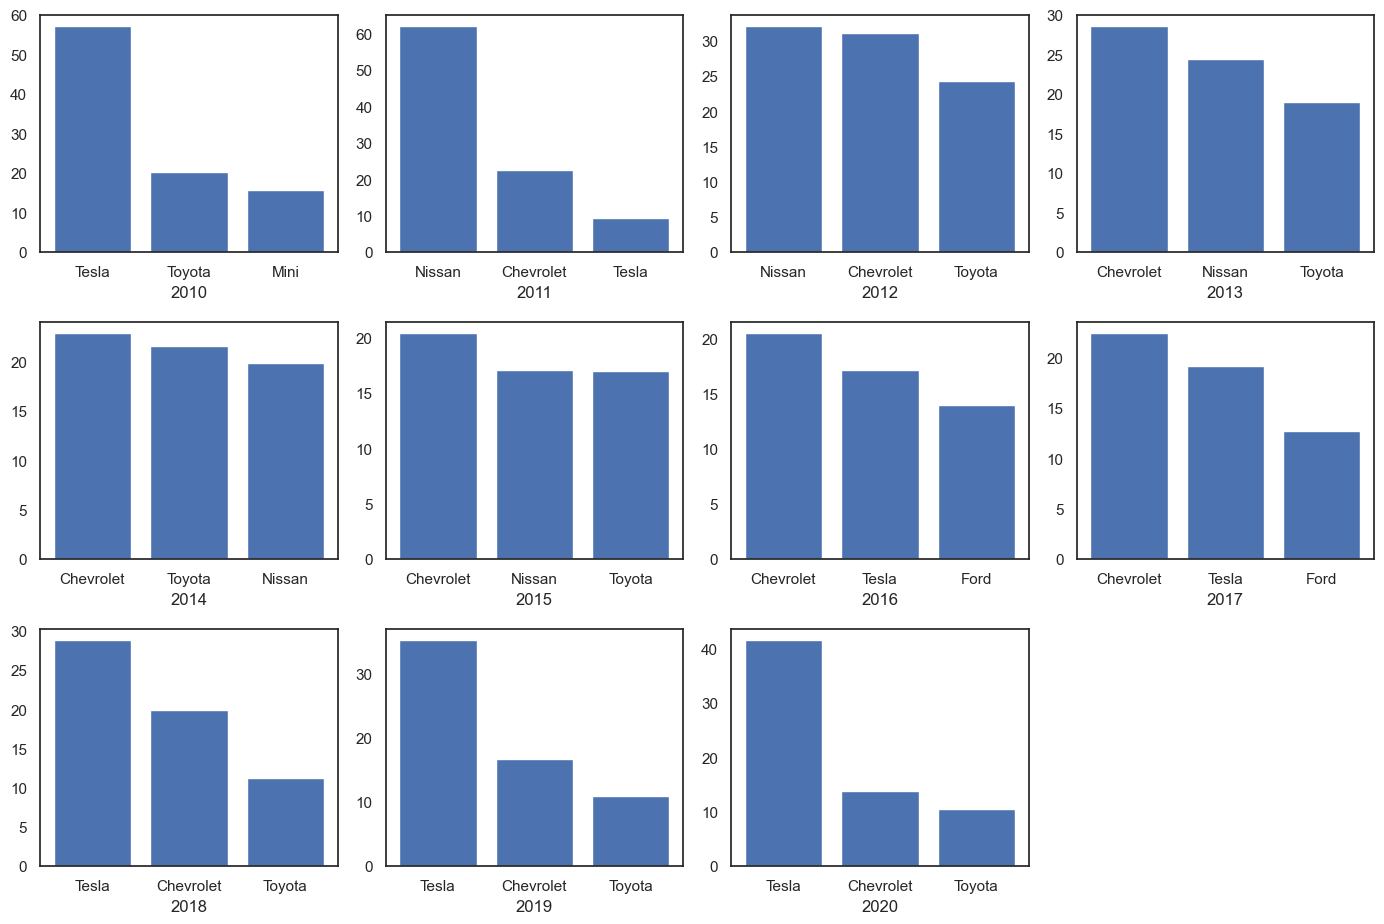

In [40]:
nr_rows = 4
nr_cols = 4
sns.set(style='white')
fig, axs = plt.subplots(nr_rows, nr_cols, figsize=(nr_cols*3.5,nr_rows*3))

for r in range(0,nr_rows):
    
    for c in range(0,nr_cols):  
        i = r*nr_cols+c
        
        if i < len(df_year_make):
            year=df_year_make.index[i]
            df=100*df_year_make.iloc[i].sort_values(ascending=False)[:3]/df_year_make.iloc[i].sum()
            # print(df.values)
            axs[r][c].bar(x=df.index.to_list(),height=df.values)
            # sns.distplot(x=X[descriptors[i]],color="green", ax = axs[r][c],bins=40,kde=True)
        #     # print()
            axs[r][c].set_xlabel(year)
        else:
            fig.delaxes(axs[r][c])
            
plt.tight_layout()    
# # plt.savefig("./Figures/Ered_desc2.png",dpi=300)
plt.show()  